# Notebook for Phenol Red Assay pH Measurement

### Equation
$$
pH = a + b \cdot \ln(A_{560})
$$
* Where A_{560} is the Absorbance at 560 nm, measured using the Tecan Spark  
* $ a$ and $ b$ are fit with data from the standards using the code below
* Sample pH is calculated using the fitted equation

### Importing Dataframes

In [1]:
import pandas as pd
import numpy as np
import re
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

### Fitting Standards

Loading Data

In [38]:
# Load plate with standards
# If your files are excel files, use the converter at the bottom
df = pd.read_csv('data/P1R1_pH.csv', index_col=0)

# Standard values and positions
std_ph = [4.96, 5.96, 7.02, 8.0]  # Fill pH values
std_pos = ['C5', 'D5', 'E5', 'F5']  # Corresponding well positions

#Load plate with samples to convert
plate_df = pd.read_csv('data/P1R1_pH.csv', index_col=0)

#Output file name
op_name = 'data/P1R1_ph_result.csv'

Parsing and Running Checks

In [39]:
# Ensure all column names are clean strings
df.columns = [str(col).strip().split('.')[0] for col in df.columns]
plate_df.columns = [str(col).strip().split('.')[0] for col in plate_df.columns]

a560_values = []

assert len(std_ph) == len(std_pos), "Enter equal pH values and well positions"
assert len(std_ph) >= 4, "Have at least 4 points in your calibration curve"

for pos in std_pos:
    match = re.fullmatch(r'([A-H])(\d{1,2})', pos)
    if not match:
        raise ValueError(f"Invalid position format or out of bounds: {pos}")
    
    row, col = match.groups()
    col = int(col)
    
    if col < 1 or col > 12:
        raise ValueError(f"Column out of range in position: {pos}")
    
    try:
        a560 = df.loc[row, str(col)]
        a560_values.append(a560)
    except KeyError:
        raise ValueError(f"Invalid position in data: {pos}")

Manually entering values (Optional)

In [40]:
a560_values = np.array([0.0494,0.0757,0.262,1.0504,0.0489,0.0757,0.265,1.043,0.0492,0.0766,0.2702,1.0631])
std_ph = np.array([4.96,5.96,7.02,8.00,4.96,5.96,7.02,8.00,4.96,5.96,7.02,8.00])

Fitting Equation

In [41]:
a560_values = np.array(a560_values)
ln_a560 = np.log(a560_values)
std_ph = np.array(std_ph)

# Fit model: pH = a + b * ln(A560)
def model(x, a, b):
    return a + b * x

params, _ = curve_fit(model, ln_a560, std_ph)
a_fit, b_fit = params

print(f"Fitted equation: pH = {a_fit:.4f} + {b_fit:.4f} * ln(A560)")

Fitted equation: pH = 8.0860 + 0.9330 * ln(A560)


Plotting the Fit

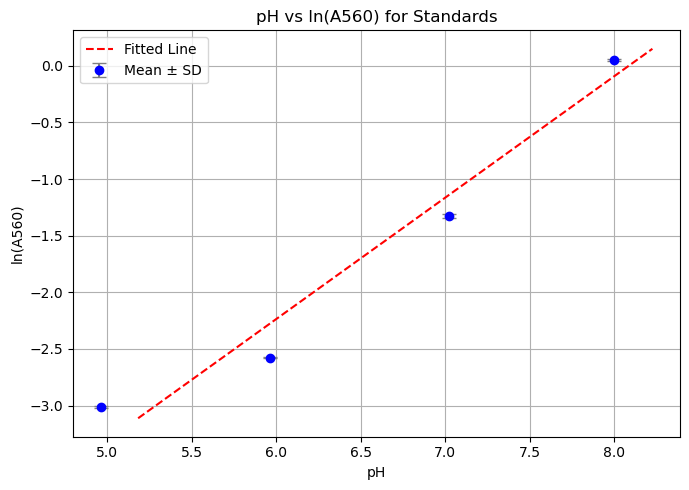

In [42]:
# Build a DataFrame for easy grouping
df_plot = pd.DataFrame({
    'pH': std_ph,
    'ln_A560': ln_a560
})

# Group by pH and compute mean and std dev of log(A560)
grouped = df_plot.groupby('pH').agg(
    mean_ln_A560=('ln_A560', 'mean'),
    std_ln_A560=('ln_A560', 'std')
).reset_index()

# Generate fitted line
x_vals = np.linspace(grouped['mean_ln_A560'].min() - 0.1,
                     grouped['mean_ln_A560'].max() + 0.1, 100)
y_vals = model(x_vals, *params)

# Plot
plt.figure(figsize=(7, 5))
plt.errorbar(grouped['pH'], grouped['mean_ln_A560'], 
             yerr=grouped['std_ln_A560'], fmt='o', color='blue', 
             ecolor='gray', capsize=5, label='Mean ± SD')

plt.plot(y_vals, x_vals, color='red', linestyle='--', label='Fitted Line')  # flip axis
plt.xlabel('pH')
plt.ylabel('ln(A560)')
plt.title('pH vs ln(A560) for Standards')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Calculating pH for Samples

In [43]:
def convert_a560_to_ph(df_a560, a, b):
    """
    Convert a DataFrame of A560 values to pH using the formula: pH = a + b * ln(A560)
    
    Parameters:
        df_a560 (pd.DataFrame): DataFrame with A560 values (indexed by A-H, columns 1-12 as strings)
        a (float): Intercept from the fitted model
        b (float): Slope from the fitted model
        
    Returns:
        pd.DataFrame: New DataFrame with pH values
    """
    # Avoid log(0) or negative values
    if (df_a560 <= 0).any().any():
        raise ValueError("All A560 values must be positive to compute logarithm.")
    
    df_ln_a560 = np.log(df_a560)
    df_ph = a + b * df_ln_a560
    return df_ph

In [ ]:
df_ph = convert_a560_to_ph(plate_df, a_fit, b_fit)

# Save Output
df_ph.to_csv(op_name, index=False)

### Running Multiple Plates of Samples

In [47]:
# If you're running multiple samples with a single standard fit
# load the standard fit into a_fit and b_fit
# Then load file names as list of csv and run block
input_ls = [f'data/P{i}R{j}_pH.csv' for i in range(1,3) for j in range(1,4)]
op_ls = [f'data/P{i}R{j}_ph_result.csv' for i in range(1,3) for j in range(1,4)]


for input_file,op_name in zip(input_ls,op_ls):

    #Load plate with samples to convert
    plate_df = pd.read_csv(input_file, index_col=0)

    df_ph = convert_a560_to_ph(plate_df, a_fit, b_fit)

    # Save Output
    df_ph.to_csv(op_name, index=True)

### Excel to csv converter for Spark

In [14]:
import os
import pandas as pd
import string

class ExcelToCSVConverter:
    def __init__(self, directory: str):
        self.directory = directory

    def convert_all(self):
        for filename in os.listdir(self.directory):
            if filename.endswith(".xlsx"):
                full_path = os.path.join(self.directory, filename)
                print(f"Processing: {filename}")
                self._process_file(full_path)

    def _process_file(self, filepath: str):
        # Read Excel without interpreting headers
        df = pd.read_excel(filepath, header=None)

        # Find index of the marker row
        marker_index = df[df[0] == "<>"].index
        if marker_index.empty:
            print(f"Skipped (no marker): {os.path.basename(filepath)}")
            return

        # Extract and convert marker row to a list with integers where possible
        marker_row_raw = df.loc[marker_index[0]].tolist()
        marker_row = [self._try_convert_to_int(val) for val in marker_row_raw]

        # Get all rows after the marker
        data_rows = df.loc[marker_index[0] + 1:]

        # Prepare output with converted marker row first
        filtered_rows = [marker_row]

        # Capital letter sequence: A, B, C, ...
        expected_letters = list(string.ascii_uppercase)
        expected_index = 0

        for _, row in data_rows.iterrows():
            val = row[0]

            if (
                isinstance(val, str) and
                expected_index < len(expected_letters) and
                val == expected_letters[expected_index]
            ):
                filtered_rows.append(row.tolist())
                expected_index += 1
            else:
                break  # Sequence broken — stop reading

        # Save output CSV if there are any valid rows
        if len(filtered_rows) > 1:
            result_df = pd.DataFrame(filtered_rows)
            output_filename = os.path.splitext(os.path.basename(filepath))[0] + ".csv"
            output_path = os.path.join(self.directory, output_filename)
            result_df.to_csv(output_path, index=False, header=False)
            print(f"Saved: {output_filename}")
        else:
            print(f"No valid sequence found in: {os.path.basename(filepath)}")

    def _try_convert_to_int(self, value):
        # Try to convert value to int, otherwise return as is
        try:
            return int(value)
        except (ValueError, TypeError):
            return value

In [ ]:
data_folder = 'data'

# Will convert all excel files into csvs in the folder
converter = ExcelToCSVConverter(data_folder)
converter.convert_all()

Processing: P1R3_pH.xlsx
Saved: P1R3_pH.csv
Processing: P1R2_pH.xlsx
Saved: P1R2_pH.csv
Processing: P1R1_pH.xlsx
Saved: P1R1_pH.csv
Processing: P2R1_pH.xlsx
Saved: P2R1_pH.csv
Processing: P2R3_pH.xlsx
Saved: P2R3_pH.csv
Processing: P2R2_pH.xlsx
Saved: P2R2_pH.csv
